In [6]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [7]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA


In [8]:
import numpy as np
import pandas as pd

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

# Função OBV ajustada
def obv(group, smoothed_col):
    Volume = group['Volume']
    change = group[smoothed_col].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, Volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index=group.index)

# Lista de alphas e parâmetros gerais
alpha_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
n = 15
d = 10
e = 14

# Loop para cálculos por alpha
for alpha in alpha_list:
    smoothed_col = f'Smoothed_Close_{alpha:.2f}'
    target_col = f'Prediction_{alpha:.2f}'
    obv_col = f'OBV_{alpha:.2f}'
    price_rate_col = f'Price_Rate_Of_Change_{alpha:.2f}'
    macd_col = f'MACD_{alpha:.2f}'
    macd_ema_col = f'MACD_EMA_{alpha:.2f}'
    low_col = f'low_14_{alpha:.2f}'
    high_col = f'high_14_{alpha:.2f}'
    k_percent_col = f'k_percent_{alpha:.2f}'
    r_percent_col = f'r_percent_{alpha:.2f}'
    
    # Suavização exponencial
    price_data[smoothed_col] = price_data.groupby('Ticker')['Close'].transform(
        lambda x: exponential_smoothing(x.values, alpha)
    )
    
    # Target
    price_data[target_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: calculate_target(x, d)
    )
    
    # OBV
    obv_groups = price_data.groupby('Ticker').apply(lambda group: obv(group, smoothed_col))
    price_data[obv_col] = obv_groups.reset_index(level=0, drop=True)
    
    # Price Rate of Change
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: x.pct_change(periods=e)
    )
    
    
    # %R
    low_14 = price_data[['Ticker', 'Low']].copy()
    high_14 = price_data[['Ticker', 'High']].copy()
    low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=n).min())
    high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=n).max())
    r_percent = ((high_14 - price_data[smoothed_col]) / (high_14 - low_14)) * (-100)
    price_data[low_col] = low_14
    price_data[high_col] = high_14
    price_data[r_percent_col] = r_percent

    # %K    
    k_percent = ((price_data[smoothed_col] - low_14) / (high_14 - low_14)) * 100
    price_data[k_percent_col] = k_percent
    
    # MACD
    ema_26 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=26).mean())
    ema_12 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span=9).mean()
    price_data[macd_col] = macd
    price_data[macd_ema_col] = ema_9_macd

    # Calculando o Price Rate of Change (ROC) usando a coluna suavizada correspondente
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.pct_change(periods=e))


# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

# Visualização final
price_data.tail()


<ipython-input-8-16f5967a2a12>:154: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
11763,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,55.960988,-1.0,2569603048,-0.044086,53.330002,60.189999,-61.647407,38.352593,-0.922360,-0.785855,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,54.664059,-1.0,288773962,-0.062256,53.330002,60.189999,-80.553095,19.446905,-1.161412,-0.997203,54.534627,-1.0,697626766,-0.066515,53.330002,60.189999,-82.439860,17.560140,-1.189353,-1.035174,54.464443,-1.0,625523526,-0.070314,53.330002,60.189999,-83.462951,16.537049,-1.199478,-1.057496,54.410308,-1.0,365924838,-0.074368,53.330002,60.189999,-84.252094,15.747906,-1.203018,-1.070986,54.362226,-1.0,557855542,-0.078769,53.330002,60.189999,-84.953001,15.046999,-1.204547,-1.079605,54.319392,-1.0,-1044184842,-0.083430,53.330002,60.189999,-85.577390,14.422610,-1.205625,-1.085483,54.282151,-1.0,-878473538,-0.088270,53.330002,60.189999,-86.120269,13.879731,-1.206660,-1.089744,0.299999,0.0,33.141092,54.250000,-1.0,52.669998
11764,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,55.688890,-1.0,2545994348,-0.050726,52.880001,59.939999,-60.214027,39.785973,-0.958395,-0.820363,54.640498,-1.0,2140229070,-0.066544,52.880001,59.939999,-75.063780,24.936220,-1.130935,-0.972229,54.236842,-1.0,265165262,-0.076603,52.880001,59.939999,-80.781287,19.218713,-1.197801,-1.037322,54.016777,-1.0,674018066,-0.083845,52.880001,59.939999,-83.898355,16.101645,-1.226695,-1.073479,53.852222,-1.0,601914826,-0.089978,52.880001,59.939999,-86.229157,13.770843,-1.241093,-1.094215,53.708124,-1.0,342316138,-0.095438,52.880001,59.939999,-88.270208,11.729792,-1.250832,-1.106955,53.576669,1.0,534246842,-0.100189,52.880001,59.939999,-90.132181,9.867819,-1.259260,-1.115536,53.455880,1.0,-1067793542,-0.104123,52.880001,59.939999,-91.843074,8.156926,-1.267292,-1.121844,53.344217,1.0,-902082238,-0.107161,52.880001,59.939999,-93.424707,6.575293,-1.275103,-1.126816,1.009998,0.0,26.456467,53.240002,1.0,54.490002
11765,2025-01-06,53.480000,53.790001,52.480000,52.560001,52.560001,21689500,VALE3.SA,-0.680000,55.376001,-1.0,2524304848,-0.056341,52.480000,59.590000,-59.268620,40.731380,-1.000665,-0.856423,54.224398,-1.0,2118539570,-0.074615,52.480000,59.590000,-75.465560,24.534440,-1.180967,-1.013977,53.733790,-1.0,243475762,-0.085652,52.480000,59.590000,-82.365823,17.634177,-1.252790,-1.080416,53.434067,1.0,652328566,-0.092988,52.480000,59.590000,-86.581336,13.418664,-1.288456,-1.116474,53.206112,1.0,580225326,-0.09833

#### Se quiser rodar para um Ticker.

In [10]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
5733,2025-01-02,11.72,11.89,11.49,11.60,11.60,33417900,ABEV3.SA,-0.139999,12.610356,-1.0,-2942674493,-0.049996,11.49,14.50,-62.778873,37.221127,-0.020121,0.057392,12.232996,-1.0,-2565304547,-0.106219,11.49,14.50,-75.315739,24.684261,-0.117013,0.027268,11.995998,-1.0,-2740522273,-0.139924,11.49,14.50,-83.189431,16.810569,-0.190249,-0.014482,11.860781,-1.0,-2039324923,-0.158473,11.49,14.50,-87.681694,12.318306,-0.234993,-0.046225,11.776287,-1.0,-1785625905,-0.168925,11.49,14.50,-90.488806,9.511194,-0.262844,-0.068402,11.717846,-1.0,-1473288787,-0.175025,11.49,14.50,-92.430359,7.569641,-0.281425,-0.084130,11.674678,-1.0,-1807056775,-0.178720,11.49,14.50,-93.864505,6.135495,-0.294676,-0.095693,11.641927,-1.0,-1716987435,-0.181053,11.49,14.50,-94.952578,5.047422,-0.304631,-0.104505,11.617379,-1.0,-1652036573,-0.182594,11.49,14.50,-95.768133,4.231867,-0.312389,-0.111431,0.139999,0.00,18.939456,11.60,-1.0,11.08
5734,2025-01-03,11.49,11.55,11.27,11.33,11.33,41365900,ABEV3.SA,-0.270000,12.482320,-1.0,-2984040393,-0.066645,11.27,14.50,-62.466876,37.533124,-0.056086,0.034696,12.052397,-1.0,-2606670447,-0.126855,11.27,14.50,-75.777198,24.222802,-0.169565,-0.012098,11.796199,-1.0,-2781888173,-0.160073,11.27,14.50,-83.709035,16.290965,-0.247106,-0.061007,11.648468,-1.0,-2080690823,-0.177636,11.27,14.50,-88.282723,11.717277,-0.292904,-0.095561,11.553143,-1.0,-1826991805,-0.187541,11.27,14.50,-91.233966,8.766034,-0.321308,-0.118983,11.485138,-1.0,-1514654687,-0.193661,11.27,14.50,-93.339383,6.660617,-0.340433,-0.135391,11.433403,-1.0,-1848422675,-0.197857,11.27,14.50,-94.941085,5.058915,-0.354243,-0.147403,11.392385,-1.0,-1758353335,-0.201047,11.27,14.50,-96.210993,3.789007,-0.364743,-0.156553,11.358738,-1.0,-1693402473,-0.203692,11.27,14.50,-97.252713,2.747287,-0.373033,-0.163751,0.270000,0.00,15.985276,11.33,-1.0,11.09
5735,2025-01-06,11.36,11.50,11.21,11.29,11.29,50881500,ABEV3.SA,-0.040000,12.363088,-1.0,-3034921893,-0.078499,11.21,14.36,-63.394023,36.605977,-0.093136,0.009130,11.899917,-1.0,-2657551947,-0.137859,11.21,14.36,-78.097857,21.902143,-0.220969,-0.053872,11.644339,-1.0,-2832769673,-0.166536,11.21,14.36,-86.211461,13.788539,-0.300950,-0.108995,11.505081,-1.0,-2131572323,-0.179309,11.21,14.36,-90.632347,9.367653,-0.346377,-0.145724,11.421572,-1.0,-1877873305,-0.184755,11.21,14.36,-93.283440,6.716560,-0.373947,-0.169976,11.368055,-1.0,-1565536187,-0.186684,11.21,14.36,-94.982372,5.017628,-0.392125,-0.186738,11.333021,-1.0,-1899304175,-0.186785,11.21,14.36,-96.094572,3.905428,-0.404883,-0.

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data.tail()

#### Se quiser normal só pular etapa anterior.

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Para cada alpha, criar as variáveis X_Cols e Y_Cols e treinar o modelo
for alpha in alpha_list:
    # Definindo as colunas de X e Y dinamicamente
    X_Cols = price_data[['RSI',
                         f'k_percent_{alpha:.2f}',
                         f'r_percent_{alpha:.2f}',
                         f'Price_Rate_Of_Change_{alpha:.2f}',
                         f'MACD_{alpha:.2f}',
                         f'MACD_EMA_{alpha:.2f}',
                         f'OBV_{alpha:.2f}']]
    
    Y_Cols = price_data[f'Prediction_{alpha:.2f}']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

    # Criar o classificador Random Forest
    rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

    # Ajustar o modelo
    rand_frst_clf.fit(X_train, y_train)

    # Fazer previsões
    y_pred = rand_frst_clf.predict(X_test)

    # Imprimir a acurácia
    accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100.0
    print(f'Alpha: {alpha}')
    print(f'Correct Prediction (%): {accuracy:.5f}')
    print('---')


Alpha: 0.1
Correct Prediction (%): 85.18519
---
Alpha: 0.2
Correct Prediction (%): 80.64291
---
Alpha: 0.3
Correct Prediction (%): 78.75611
---
Alpha: 0.4
Correct Prediction (%): 74.84277
---
Alpha: 0.5
Correct Prediction (%): 73.72467
---
Alpha: 0.6
Correct Prediction (%): 72.81621
---
Alpha: 0.7
Correct Prediction (%): 72.74633
---
Alpha: 0.8
Correct Prediction (%): 72.74633
---
Alpha: 0.9
Correct Prediction (%): 71.90776
---


In [26]:
import warnings
from datetime import timedelta

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Filtrar últimos 30 dias
last_30_days = price_data[price_data['Date'] >= price_data['Date'].max() - timedelta(days=30)]

# Para cada alpha, selecionar as colunas de X, gerar previsões e comparar com a coluna 'Verify'
for alpha in alpha_list:
    # Selecionar as colunas de X como um array NumPy
    X_Cols = last_30_days[['RSI',
                           f'k_percent_{alpha:.2f}',
                           f'r_percent_{alpha:.2f}',
                           f'Price_Rate_Of_Change_{alpha:.2f}',
                           f'MACD_{alpha:.2f}',
                           f'MACD_EMA_{alpha:.2f}',
                           f'OBV_{alpha:.2f}']].values

    # Gerar previsões e atualizar a coluna 'Prediction_{alpha}' para os últimos 30 dias
    last_30_days[f'Prediction_{alpha:.2f}'] = rand_frst_clf.predict(X_Cols)

    # Comparar as previsões de 'Prediction_{alpha}' com 'Verify' e calcular a precisão
    last_30_days['Match'] = (last_30_days[f'Prediction_{alpha:.2f}'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
    accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

    # Imprimir a precisão para cada alpha
    print(f'\nPrecisão para Alpha: {alpha}')
    print(f'Precisão do modelo nos últimos 30 dias: {accuracy:.2%}')



Precisão para Alpha: 0.1
Precisão do modelo nos últimos 30 dias: 68.42%

Precisão para Alpha: 0.2
Precisão do modelo nos últimos 30 dias: 89.47%

Precisão para Alpha: 0.3
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.4
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.5
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.6
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.7
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.8
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.9
Precisão do modelo nos últimos 30 dias: 100.00%


#### Time Series com Verify e plotagem

Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 60.90%
 - Correct Prediction (Verify): 49.16%
Fold 2:
 - Correct Prediction (y_test): 67.82%
 - Correct Prediction (Verify): 48.74%
Fold 3:
 - Correct Prediction (y_test): 61.64%
 - Correct Prediction (Verify): 40.67%
Fold 4:
 - Correct Prediction (y_test): 64.05%
 - Correct Prediction (Verify): 57.44%
Fold 5:
 - Correct Prediction (y_test): 70.65%
 - Correct Prediction (Verify): 51.57%
Média de acurácia (y_test) para alpha 0.1: 65.01%
Média de acurácia (Verify) para alpha 0.1: 49.52%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 53.25%
 - Correct Prediction (Verify): 50.21%
Fold 2:
 - Correct Prediction (y_test): 59.22%
 - Correct Prediction (Verify): 55.24%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.70%
Fold 4:
 - Correct Prediction (y_test): 58.60%
 - Correct Prediction (Verify): 55.45%
Fold 5:
 - Correct Prediction (y_test): 55.45%
 - Correct Prediction (Verify): 48.32%
Média de acurá

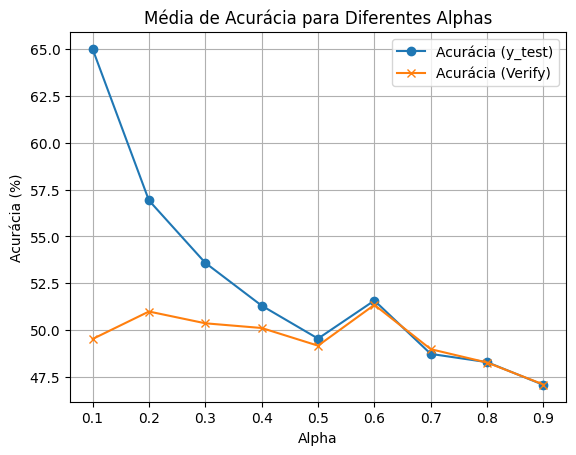

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []
alpha_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]  # Definindo a lista de alphas de 0.01 a 0.99

# Criar uma lista para armazenar as médias das acurácias por alpha
mean_accuracy_by_alpha = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse alpha
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por alpha
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_alpha.append((alpha, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para alpha {alpha}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para alpha {alpha}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for alpha, acc_ytest, acc_verify in mean_accuracy_by_alpha:
    print(f'Alpha: {alpha:.2f} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por alpha
import matplotlib.pyplot as plt

alphas, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_alpha)

plt.plot(alphas, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(alphas, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Alphas")
plt.xlabel('Alpha')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()


#### Time Series com verify

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar os resultados das acurácias
        all_accuracy_scores_ytest.append(accuracy_ytest)
        all_accuracy_scores_verify.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    print('---')

# Resultados gerais
print("Resumo geral:")
print(f'Média de acurácia (y_test): {np.mean(all_accuracy_scores_ytest):.2f}%')
print(f'Média de acurácia (Verify): {np.mean(all_accuracy_scores_verify):.2f}%')


Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 60.90%
 - Correct Prediction (Verify): 49.16%
Fold 2:
 - Correct Prediction (y_test): 67.82%
 - Correct Prediction (Verify): 48.74%
Fold 3:
 - Correct Prediction (y_test): 61.64%
 - Correct Prediction (Verify): 40.67%
Fold 4:
 - Correct Prediction (y_test): 64.05%
 - Correct Prediction (Verify): 57.44%
Fold 5:
 - Correct Prediction (y_test): 70.65%
 - Correct Prediction (Verify): 51.57%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 53.25%
 - Correct Prediction (Verify): 50.21%
Fold 2:
 - Correct Prediction (y_test): 59.22%
 - Correct Prediction (Verify): 55.24%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.70%
Fold 4:
 - Correct Prediction (y_test): 58.60%
 - Correct Prediction (Verify): 55.45%
Fold 5:
 - Correct Prediction (y_test): 55.45%
 - Correct Prediction (Verify): 48.32%
---
Alpha: 0.3
Fold 1:
 - Correct Prediction (y_test): 49.37%
 - Correct Prediction (Verify): 48.22%
Fold 2:
 - Co

#### Time Series sem Verify

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X) e o target (Y) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y], axis=1).dropna()
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0,oob_score = True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Calcular e imprimir a acurácia para cada divisão
        accuracy = accuracy_score(y_test, y_pred) * 100.0
        print(f'Fold {fold}: Correct Prediction (%): {accuracy:.2f}')
        fold += 1

    print('---')


#### Salvando

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

In [ ]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/test_day.xlsx', index=False)